In [1]:
def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

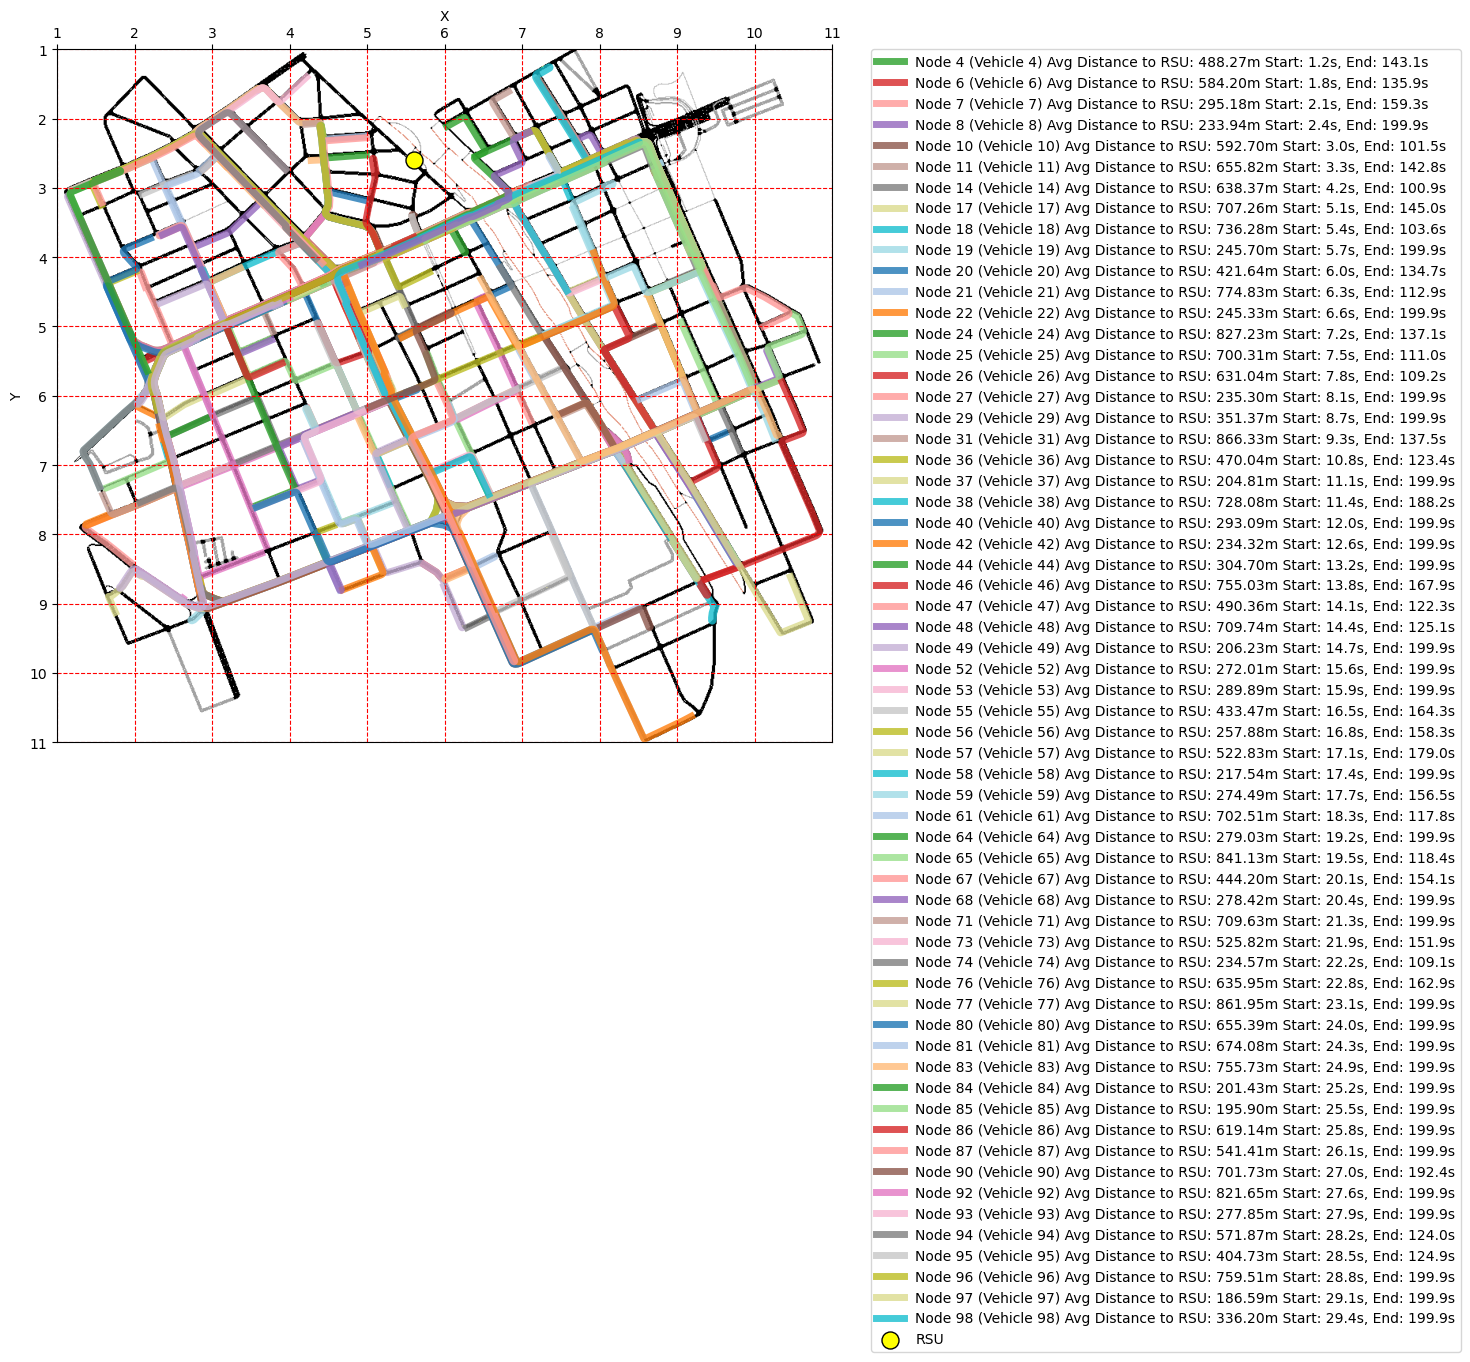

In [37]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width = 1300, map_height = 1600, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_average_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.mean(distances)

    #plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
def plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height, grid_size=10, rsu_x=560, rsu_y=1160):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 9))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()

    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        avg_distance_to_rsu = calculate_average_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        
        
        if start_time < 30 and end_time >= 100:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) Avg Distance to RSU: {avg_distance_to_rsu:.2f}m Start: {start_time:.1f}s, End: {end_time:.1f}s', 
                zorder=1
            )
        else:
            plt.plot(
                vehicle_data['x'] - dx, vehicle_data['y'] - dy, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                zorder=1
            )

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()

def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_high.txt')

    target_node_ids = [i for i in range(0, 131)]
    # 4 6 7 8 10 11 14 17 18 
    # 19 20 21 22 24 25 26
    # 19 21 
    #target_node_ids = [22, 24, 25]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    dx, dy = 230, 330
    map_width=1540
    map_height=1380
    data = extract_data_from_xml('resource/map2.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    plot_data(data, node_to_vehicle_map, dx, dy, map_width, map_height)

if __name__ == "__main__":
    main()

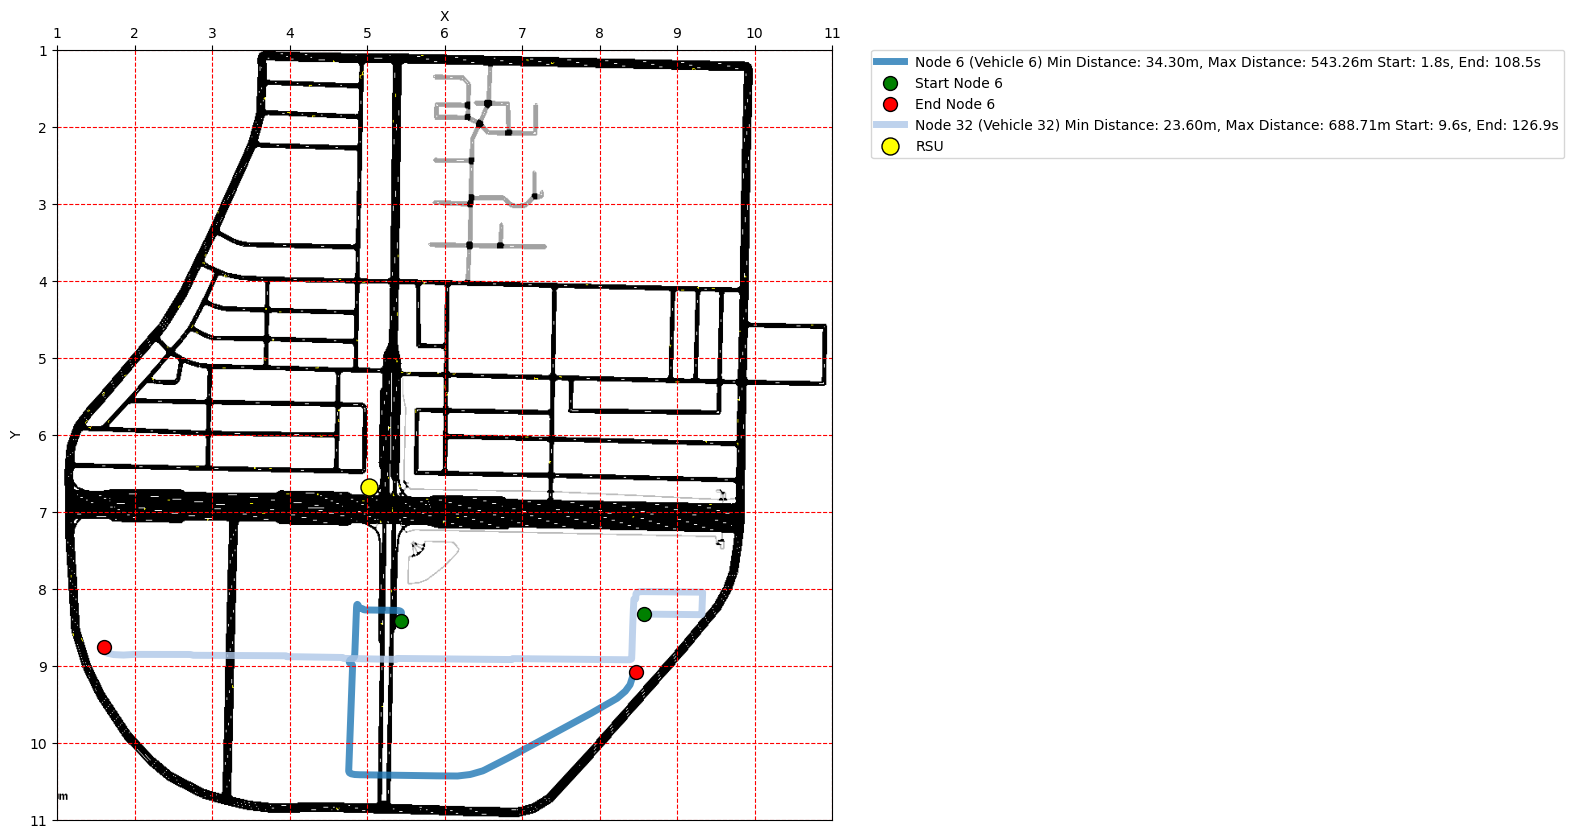

In [4]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from collections import defaultdict
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FixedFormatter, FixedLocator

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width=1370, map_height=2650, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_min_max_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.min(distances), np.max(distances)


def plot_data(data, node_to_vehicle_map, map_width=1390, map_height=2690, grid_size=10, rsu_x=880, rsu_y=870):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 10))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)

    unique_vehicle_ids = data['vehicle_id'].unique()
    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        min_distance_to_rsu, max_distance_to_rsu = calculate_min_max_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        x_values = vehicle_data['x'] - 380
        y_values = vehicle_data['y'] - 280

        # 출발 지점과 도착 지점 계산
        first_x, first_y = x_values.iloc[0], y_values.iloc[0]
        last_x, last_y = x_values.iloc[-1], y_values.iloc[-1]

        if start_time < 30 and end_time >= 100:
            plt.plot(
                x_values, y_values, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) Min Distance: {min_distance_to_rsu:.2f}m, Max Distance: {max_distance_to_rsu:.2f}m Start: {start_time:.1f}s, End: {end_time:.1f}s', 
                zorder=1
            )
        else:
            plt.plot(x_values, y_values, color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, zorder=1)

        # 출발 지점 마커 (초록색)
        plt.scatter(first_x, first_y, color='green', s=100, edgecolors='black', label=f'Start Node {node_id}' if vehicle_id == unique_vehicle_ids[0] else "", zorder=3)

        # 도착 지점 마커 (빨간색)
        plt.scatter(last_x, last_y, color='red', s=100, edgecolors='black', label=f'End Node {node_id}' if vehicle_id == unique_vehicle_ids[0] else "", zorder=3)

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # RSU 위치 표시 (노란색)
    plt.scatter(map_width - 830, 1160, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()


def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_high.txt')

    target_node_ids = [6, 32]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    data = extract_data_from_xml('resource/map2.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    plot_data(data, node_to_vehicle_map)

if __name__ == "__main__":
    main()


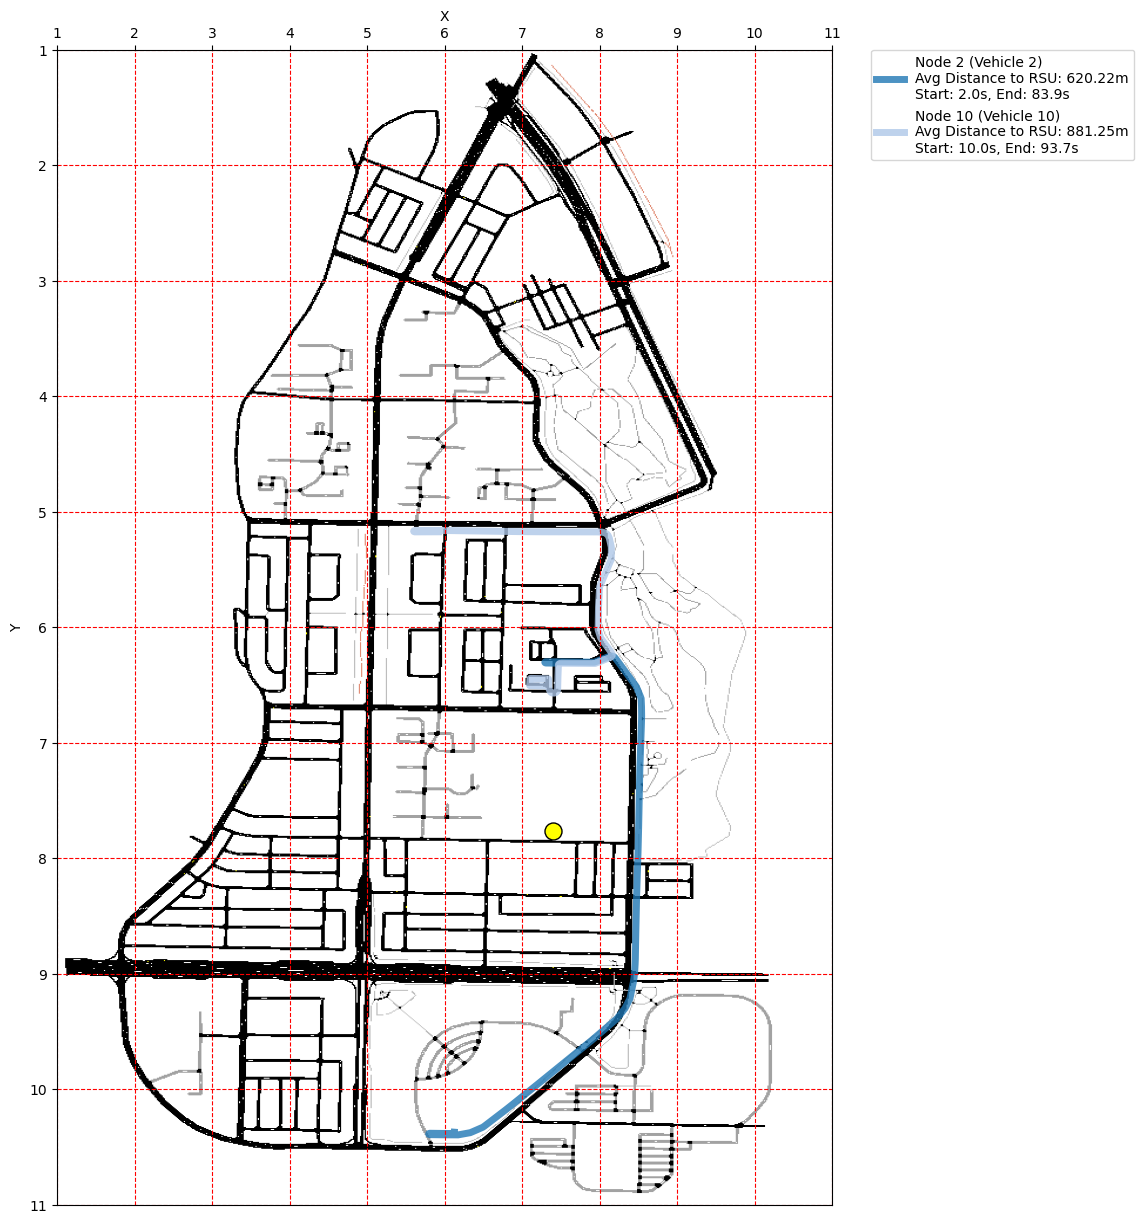

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.cm as cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import xml.etree.ElementTree as ET # type: ignore
from collections import defaultdict # type: ignore
import matplotlib.patheffects as path_effects # type: ignore
from matplotlib.ticker import FixedFormatter, FixedLocator # type: ignore

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width=1370, map_height=2650, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_average_distance_to_rsu(data, rsu_x, rsu_y):
    distances = []
    for _, row in data.iterrows():
        distance = np.sqrt((row['x'] - rsu_x)**2 + (row['y'] - rsu_y)**2)
        distances.append(distance)
    return np.mean(distances)

def plot_data(data, node_to_vehicle_map, map_width=1390, map_height=2690, grid_size=10, rsu_x=880, rsu_y=870):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(10, 15))
    bg_img = mpimg.imread('resource/background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()

    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    legend_entries = []

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]

        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        avg_distance_to_rsu = calculate_average_distance_to_rsu(vehicle_data, rsu_x, rsu_y)

        plt.plot(
            vehicle_data['x'] - 380 , vehicle_data['y'] - 270, 
            color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5, 
            zorder=1
        )

        # 범례 항목 추가 (모든 target_node_ids 포함)
        legend_entries.append(
            f'Node {node_id} (Vehicle {vehicle_id})\n'
            f'Avg Distance to RSU: {avg_distance_to_rsu:.2f}m\n'
            f'Start: {start_time:.1f}s, End: {end_time:.1f}s'
        )

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 500, 870, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)

    # 모든 노드의 정보를 포함하는 범례 추가
    plt.legend(legend_entries, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()


def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def main():
    node_table = load_node_table('resource/node_table_low.txt')

    target_node_ids = [i for i in range(0, 51)]
    target_node_ids = [2, 10]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]

    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    data = extract_data_from_xml('resource/map0.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    plot_data(data, node_to_vehicle_map)

if __name__ == "__main__":
    main()

In [1]:
def remove_duplicates_from_file(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    seen = set()
    unique_lines = []
    
    for line in lines:
        if line not in seen:
            unique_lines.append(line)
            seen.add(line)
    
    with open(output_file, 'w') as file:
        file.writelines(unique_lines)

input_file = 'resource/external_id_table_high.txt'
output_file = 'resource/node_table_high.txt'

remove_duplicates_from_file(input_file, output_file)